### Load necessary packages and libraries

In [41]:
import numpy as np
import pandas as pd
import os
from fastai.vision.all import *
import matplotlib.pyplot as plt

from pprint import pprint

In [35]:
from fastai.vision import models
vars(models)

{'__name__': 'fastai.vision.models',
 '__doc__': None,
 '__package__': 'fastai.vision.models',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x2aa4e41bbe0>,
 '__spec__': ModuleSpec(name='fastai.vision.models', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000002AA4E41BBE0>, origin='C:\\Users\\jandr\\anaconda3\\lib\\site-packages\\fastai\\vision\\models\\__init__.py', submodule_search_locations=['C:\\Users\\jandr\\anaconda3\\lib\\site-packages\\fastai\\vision\\models']),
 '__path__': ['C:\\Users\\jandr\\anaconda3\\lib\\site-packages\\fastai\\vision\\models'],
 '__file__': 'C:\\Users\\jandr\\anaconda3\\lib\\site-packages\\fastai\\vision\\models\\__init__.py',
 '__cached__': 'C:\\Users\\jandr\\anaconda3\\lib\\site-packages\\fastai\\vision\\models\\__pycache__\\__init__.cpython-39.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `..

# Data Exploration + Preprocessing

### Load the Data

In [2]:
# Gets file names for training, validation, and testing
train_fnames = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\train")
val_fnames = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\val")
test_fnames = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\test")

# Combine training and validation into training
all_files = train_fnames + val_fnames

# Shows the amount of images in each folder (train, val, test, all), respectively
L(train_fnames, val_fnames, test_fnames, all_files).map(len)

(#4) [5216,16,624,5232]

### Show Class Imbalance

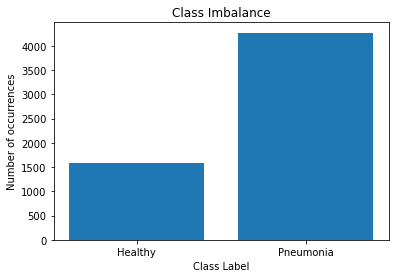

In [3]:
# Get total num of images classified as "healthy"
healthy_train = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\train\NORMAL")
healthy_val   = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\val\NORMAL")
healthy_test  = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\test\NORMAL")

tot_healthy = len(healthy_train)+len(healthy_val)+len(healthy_test)

# Get total num of images classified as "pneumonia"
pneu_train = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\train\PNEUMONIA")
pneu_val   = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\val\PNEUMONIA")
pneu_test  = get_image_files(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\test\PNEUMONIA")

tot_pneu = len(pneu_train)+len(pneu_val)+len(pneu_test)

# Bar plot amounts from each class
plt.bar(["Healthy","Pneumonia"],[tot_healthy,tot_pneu])
plt.title("Class Imbalance")
plt.xlabel("Class Label")
plt.ylabel("Number of occurrences");

### DataBlock and DataLoaders

In [14]:
# Loads all the data, so that we can do some preprocessing

path = Path(r"C:\Users\jandr\Github Repos\aBennecke\CS226_Final_Project\chest_xray\train")

# Container to build the DataLoader
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   get_items = get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   )

# Load the data into a DataLoader() specified by the above DataBlock()
dls = dblock.dataloaders(path)

In [15]:
print(f"Size of training ds:\t{len(dls.train_ds)}")
print(f"Size of valid ds:\t{len(dls.valid_ds)}")

Size of training ds:	4173
Size of valid ds:	1043


# Pretrained Model 1: resnet18

### Transfer Learning and Pretrained Models

SuggestedLRs(valley=0.0014454397605732083)

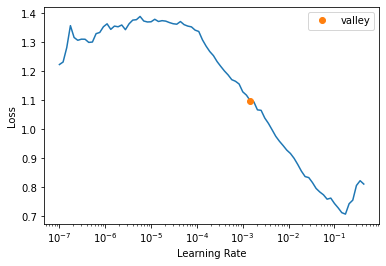

In [16]:
# Define metrics for evaluation
metrics = [accuracy, F1Score(), Precision(), Recall()]

# Construct the transfer learning model
rn18_learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=metrics)

# Find the optimal learning rate
rn18_learn.lr_find()

In [17]:
# Fit the pretrained model to our new data
rn18_learn.fine_tune(5,base_lr=1.4e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.482922,0.374002,0.909875,0.935705,0.994186,0.883721,29:18


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.146605,0.164488,0.963567,0.975033,0.991979,0.958656,37:18
1,0.072263,0.105159,0.975072,0.983182,0.984456,0.981912,36:35
2,0.032361,0.118630,0.976031,0.983692,0.993412,0.974160,35:40
3,0.017614,0.084468,0.984660,0.989583,0.997375,0.981912,35:54
4,0.010362,0.082689,0.984660,0.989583,0.997375,0.981912,35:59


### Model Interpretation

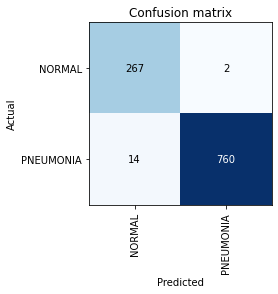

In [18]:
rn18_interp = ClassificationInterpretation.from_learner(rn18_learn)
rn18_interp.plot_confusion_matrix()

In [19]:
rn18_interp.print_classification_report()

              precision    recall  f1-score   support

      NORMAL       0.95      0.99      0.97       269
   PNEUMONIA       1.00      0.98      0.99       774

    accuracy                           0.98      1043
   macro avg       0.97      0.99      0.98      1043
weighted avg       0.99      0.98      0.98      1043



### Model Validation

In [20]:
rn18_res = rn18_learn.validate()

In [48]:
rn18_res

(#5) [0.08268925547599792,0.9846596121788025,0.9895833333333334,0.9973753280839895,0.9819121447028424]

# Pretrained Model 2: vgg16_bn

### Transfer Learning and Pretrained Models

C:\Users\jandr\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\jandr/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575)

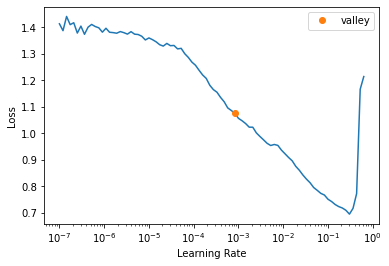

In [59]:
# Define metrics for evaluation
metrics = [accuracy, F1Score(), Precision(), Recall()]

# Construct the transfer learning model
gn_learn = vision_learner(dls, googlenet, loss_func=CrossEntropyLossFlat(), metrics=metrics)

# Find the optimal learning rate
gn_learn.lr_find()

In [ ]:
# Fit the pretrained model to our new data
lr_from_lr_find = 8.3e-4
gn_learn.fine_tune(3,base_lr=lr_from_lr_find)

### Model Interpretation

# Pretrained Model 3: alexnet

### Transfer Learning and Pretrained Models

SuggestedLRs(valley=0.0012022644514217973)

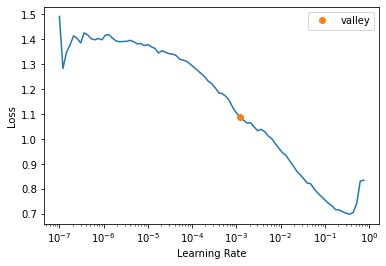

In [53]:
# Define metrics for evaluation
metrics = [accuracy, F1Score(), Precision(), Recall()]

# Construct the transfer learning model
an_learn = vision_learner(dls, alexnet, loss_func=CrossEntropyLossFlat(), metrics=metrics)

# Find the optimal learning rate
an_learn.lr_find()

In [54]:
# Fit the pretrained model to our new data
lr_from_lr_find = 1.2e-3
an_learn.fine_tune(3,base_lr=lr_from_lr_find)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.535998,0.180692,0.942474,0.959947,0.993094,0.928941,05:57


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.192868,0.119489,0.963567,0.975131,0.988064,0.962532,11:08
1,0.129113,0.079051,0.975072,0.983139,0.986979,0.979328,11:07
2,0.072321,0.085113,0.973154,0.981771,0.989501,0.974160,11:05


### Model Interpretation

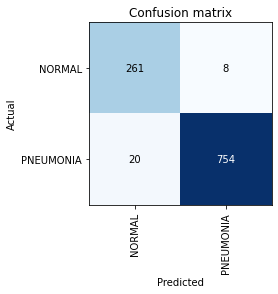

In [55]:
an_interp = ClassificationInterpretation.from_learner(an_learn)
an_interp.plot_confusion_matrix()

In [56]:
an_interp.print_classification_report()

              precision    recall  f1-score   support

      NORMAL       0.93      0.97      0.95       269
   PNEUMONIA       0.99      0.97      0.98       774

    accuracy                           0.97      1043
   macro avg       0.96      0.97      0.97      1043
weighted avg       0.97      0.97      0.97      1043



In [57]:
an_res = an_learn.validate()
an_res

(#5) [0.08511342853307724,0.9731543660163879,0.9817708333333334,0.989501312335958,0.9741602067183462]